In [1]:
import random
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from deap import base, creator, tools

from matplotlib import pyplot as plt

In [2]:
dataset = pd.read_csv('dataset.csv', delimiter=';', low_memory='False')

In [3]:
#Drop columns that are not needed
dataset = dataset.drop(['user','gender','age','how_tall_in_meters','weight','body_mass_index'], axis=1)

In [4]:

#Centering
scaler = StandardScaler(with_mean=True, with_std=False)
dataset[['x1','y1','z1','x2','y2','z2','x3','y3','z3','x4','y4','z4']] = scaler.fit_transform(dataset[['x1','y1','z1','x2','y2','z2','x3','y3','z3','x4','y4','z4']])


In [5]:
#Getting the means
means = dataset.groupby('Class')[['x1','y1','z1','x2','y2','z2','x3','y3','z3','x4','y4','z4']].mean()


In [6]:
#Separating means for the sitting state and the other states
sitting_mean = means.T.pop('sitting').T
states_means = means.T.drop('sitting', axis=1).T

sitting_mean

x1    -0.486084
y1   -22.306565
z1    43.635725
x2    28.910872
y2    -3.106982
z2    87.851017
x3     5.975411
y3   -16.033985
z3    -1.506830
x4    35.909071
y4   -17.211905
z4    -2.330129
Name: sitting, dtype: float64

In [7]:
states_means

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4
Class,,,,,,,,,,,,
sittingdown,4.760175,8.224046,-22.260180,-5.823379,-13.600041,7.620686,-8.966171,1.685927,3.775952,-15.432958,-3.437820,18.822701
standing,0.157898,9.454739,-13.615081,69.255961,105.897156,30.120579,5.579103,3.606117,5.904483,-10.540946,7.306341,2.334467
standingup,1.233943,3.038834,-26.903694,-14.638464,-22.975549,-3.290510,-24.499793,-47.574437,-10.894834,-27.935515,0.165405,5.767685
walking,-1.255743,12.595985,-22.288397,-103.568370,-101.704300,-136.530879,-3.609479,27.925607,-2.599721,-18.194113,12.997469,-6.610483


In [8]:
states_means = np.array(states_means)
sitting_mean = np.array(sitting_mean)


In [9]:
#Making the genetic algorithm

#We want to maximize fitness thus weights=1
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

#Describing the individual as a list of 12 integers from -617 to 533
toolbox = base.Toolbox()
toolbox.register("attribute", random.randint, -617,533)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=12)                 
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#Defining the evaluation function

def evaluate(v):
    c=0.1
    
    v= np.array(v).reshape(1,-1)
    other_states_sum = 0
    
    for state in states_means:
        other_states_sum += cosine_similarity(v,state.reshape(1,-1))
    
    f = ((cosine_similarity(v,sitting_mean.reshape(1,-1)) + c*(1 - 0.25 * other_states_sum)))/ (1 + c) + 1
    
    return f[0]


#Registering genetic operators
toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=0.01, low=-617, up=533)
toolbox.register("mutate", tools.mutUniformInt, low=-617,up=533, indpb=0.01)
toolbox.register("select", tools.selTournament, tournsize=40)
toolbox.register("evaluate", evaluate)


    

In [10]:
#The actual algorithm

def ga():
    
    #Create initial population
    pop = toolbox.population(n=200)
    CXPB, NGEN = 0.6, 1000
    
    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    
    
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    
    
    g=0
    
    max_fits=1
    prev_max_fits=1
    max_fits_list=[]
    
    bad_improvement_counter=0
    
    best_solution=[]
        
    while g<NGEN and bad_improvement_counter<20 and max_fits<2:
        
        
        print("\n----GEN "+ str(g+1) +"----\n")
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        
        # Clone the selected individuals
             
        offspring =list(map(toolbox.clone, offspring))
        
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            
            #Apply crossover according to crossover prob.
            if random.random() < CXPB:
                toolbox.mate(child1,child2)
                del child1.fitness.values
                del child2.fitness.values
        
        #Always apply mutation. Mutation prob. is given as argument in mutation function
        for mutant in offspring:
            toolbox.mutate(mutant)
            del mutant.fitness.values
        
        
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring
        
        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        
        #Get best solution
        best_solution = pop[fits.index(max(fits))]
        
        #Get best evaluation for current generation
        prev_max_fits = max_fits
        max_fits = max(fits)
        max_fits_list.append(max_fits)
        
        #Get improvemnet
        improvement = (max_fits/prev_max_fits)-1
        
        #If too small increase counter
        if improvement < 0.001:
            bad_improvement_counter+=1
        else:
            bad_improvement_counter=0
        
        
        #Printing statistics for each generation
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        

        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)
        
        g+=1
        


    return best_solution, max_fits_list,g
    

In [11]:
#########Plotting and getting exp. results#########

solutions=[]
max_fits=[]
generations=[]

for _ in range(20):
    solution, max_fit,gen = ga()
    solutions.append(solution)
    max_fits.append(max_fit)
    generations.append(gen)
    
mean_fit = pd.DataFrame(max_fits).mean()



----GEN 1----

  Min 1.0964353677401981
  Max 1.7984884343719694
  Avg 1.566116100476233
  Std 0.09816736366471258

----GEN 2----

  Min 1.229848180143636
  Max 1.886149348540179
  Avg 1.7318539931332435
  Std 0.07938617667908471

----GEN 3----

  Min 1.2151726547790274
  Max 1.9573911472243462
  Avg 1.8298453813278643
  Std 0.08654850470206178

----GEN 4----

  Min 1.2080706259994232
  Max 1.9588367974531038
  Avg 1.8891818092453883
  Std 0.07350609788173873

----GEN 5----

  Min 1.6332744489499622
  Max 1.9695890794923456
  Avg 1.9439785551877447
  Std 0.04518851053194153

----GEN 6----

  Min 1.529565835507177
  Max 1.9812602204845045
  Avg 1.9477015362366612
  Std 0.05616758368866806

----GEN 7----

  Min 1.6944285232733356
  Max 1.982691775193759
  Avg 1.9655687206416375
  Std 0.034857088927111604

----GEN 8----

  Min 1.6276108072094733
  Max 1.9866440157840914
  Avg 1.9699011761261465
  Std 0.04299447263013276

----GEN 9----

  Min 1.4402293669880997
  Max 1.990414273200525
  A

  Min 1.1421268863767229
  Max 1.9358321157203229
  Avg 1.8315014176624898
  Std 0.07367294523903982

----GEN 4----

  Min 1.2488102942445574
  Max 1.95322999108765
  Avg 1.886166702607307
  Std 0.08576344071731241

----GEN 5----

  Min 1.4966665422056327
  Max 1.9667072042600608
  Avg 1.9257151758705218
  Std 0.054564573183003735

----GEN 6----

  Min 1.5065559132562232
  Max 1.9785205573467755
  Avg 1.9467318146925836
  Std 0.04304101688840999

----GEN 7----

  Min 1.1354954142536748
  Max 1.9817174468751406
  Avg 1.9469064844039596
  Std 0.09862638053684536

----GEN 8----

  Min 1.3382919505018007
  Max 1.9837576465957274
  Avg 1.9678809460175575
  Std 0.06380874812508909

----GEN 9----

  Min 1.3992444449098933
  Max 1.9854002288245374
  Avg 1.9706294468265284
  Std 0.054323998302947527

----GEN 10----

  Min 1.5206097820451663
  Max 1.9899851520352483
  Avg 1.9748697731093114
  Std 0.050279502309432456

----GEN 11----

  Min 1.291712251719645
  Max 1.9962672518655515
  Avg 1.98021

  Min 1.4974018520882884
  Max 1.900479392444338
  Avg 1.8231427724830105
  Std 0.049583720249660915

----GEN 4----

  Min 1.0179656573681317
  Max 1.9225603766608712
  Avg 1.8591981553013965
  Std 0.08369038274282949

----GEN 5----

  Min 1.1410162150782959
  Max 1.9476496588545773
  Avg 1.8916244784324876
  Std 0.0852385743167321

----GEN 6----

  Min 1.45696371108347
  Max 1.9727491046575636
  Avg 1.9194562272145959
  Std 0.05177831132387918

----GEN 7----

  Min 1.281042251568616
  Max 1.977195303550792
  Avg 1.9378853884012188
  Std 0.06476094430552383

----GEN 8----

  Min 1.7441680107999709
  Max 1.9833530553728926
  Avg 1.9641678393045654
  Std 0.0315906888766096

----GEN 9----

  Min 1.5912261913939847
  Max 2.000964250175535
  Avg 1.9668033150507307
  Std 0.05309734332665428

----GEN 1----

  Min 0.9026098587678134
  Max 1.749718723391136
  Avg 1.5558831876086108
  Std 0.1043307178277036

----GEN 2----

  Min 1.3715912438496949
  Max 1.8585526088666724
  Avg 1.707175455737455

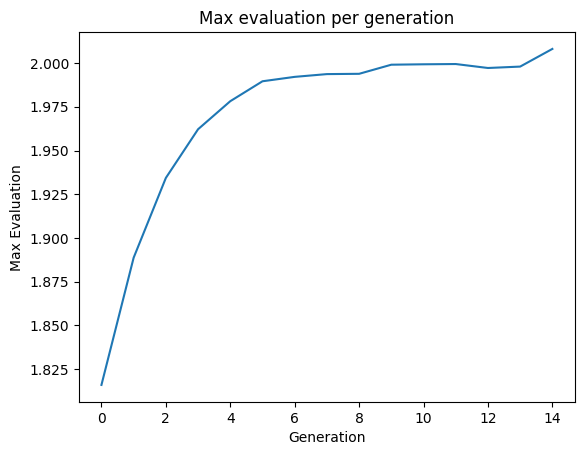

In [12]:
experiment_name = "expe"
experiment_path = "Experiments/"+experiment_name+"/"

if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

plt.title("Max evaluation per generation")
plt.xlabel("Generation")
plt.ylabel("Max Evaluation")
plt.plot(mean_fit)
plt.savefig(experiment_path+experiment_name+".jpg")

In [13]:
f = open(experiment_path+experiment_name+"_gens.txt","w")
f.write("Mean number of generations: " +str(np.mean(generations)) +"\nMean max evaluation: "+str(max(mean_fit)))
f.close()

In [14]:
best_solution = solutions[max_fits.index(max(max_fits))]
np.savetxt(experiment_path+experiment_name+"_solution.txt", best_solution, delimiter=',')